In [1]:
import cv2
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
img_path = '/kaggle/input/isic2018-challenge-task1-data-segmentation'

In [2]:
device = 'cuda'

epochs = 25
learning_rate = 1e-3
image_size = 256
batch_size = 16

In [3]:
from pathlib import Path

train_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/"
test_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input/"
val_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input/"

train_truth_path="/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth/"
test_truth_path = "/kaggle/input/isic2018-testdata/ISIC2018_Task1_Test_GroundTruth/ISIC2018_Task1_Test_GroundTruth/"
val_truth_path = "/kaggle/input/isic2018-testdata/ISIC2018_Task1_Validation_GroundTruth/ISIC2018_Task1_Validation_GroundTruth/"

# Directory containing images
image_dir = Path(train_path)
test_dir = Path(test_path)
val_dir = Path(val_path)

# Image extensions to look for
image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".webp"}

# Get all image paths
train_paths = [str(p) for p in image_dir.iterdir() if p.suffix.lower() in image_extensions]
trainm_paths = [(train_truth_path+p[-16:-4]+'_segmentation.png') for p in train_paths]

test_paths = [str(p) for p in test_dir.iterdir() if p.suffix.lower() in image_extensions]
testm_paths = [(test_truth_path+p[-16:-4]+'_segmentation.png') for p in test_paths]

valid_paths = [str(p) for p in val_dir.iterdir() if p.suffix.lower() in image_extensions]
validm_paths = [(val_truth_path+p[-16:-4]+'_segmentation.png') for p in valid_paths]

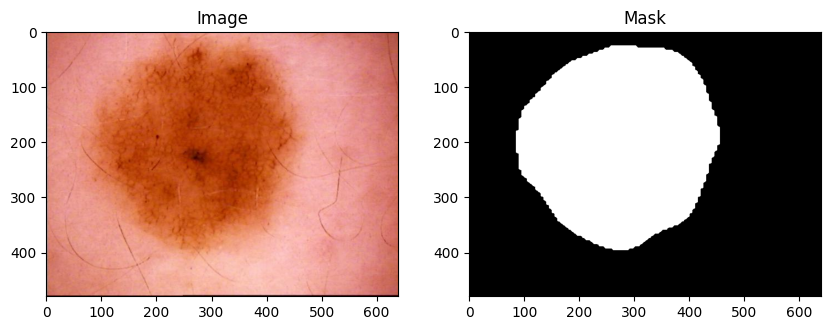

In [4]:
image_path = valid_paths[0]
mask_path = validm_paths[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.set_title('Image')
ax1.imshow(image)
ax2.set_title('Mask')
ax2.imshow(mask, cmap='gray')

In [5]:
import albumentations as A
def train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def val_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
  ])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from torch.utils.data import Dataset

class ISIC_2K18_Dataset(Dataset):
  def __init__(self, df,dft):
    self.df = df
    self.dft = dft

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image, mask = self.df[index],self.dft[index]
    image_path = image
    mask_path = mask

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(224,224))
    mask = np.expand_dims(mask, axis = -1)
      

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [7]:
trainset = ISIC_2K18_Dataset(train_paths, trainm_paths)
validset = ISIC_2K18_Dataset(valid_paths, validm_paths)
testset = ISIC_2K18_Dataset(test_paths, testm_paths)

print("The size of the training dataset is: ", len(trainset))
print("The size of the validation dataset is: ", len(validset))
print("The size of the test dataset is: ", len(testset))

The size of the training dataset is:  2594
The size of the validation dataset is:  100
The size of the test dataset is:  1000


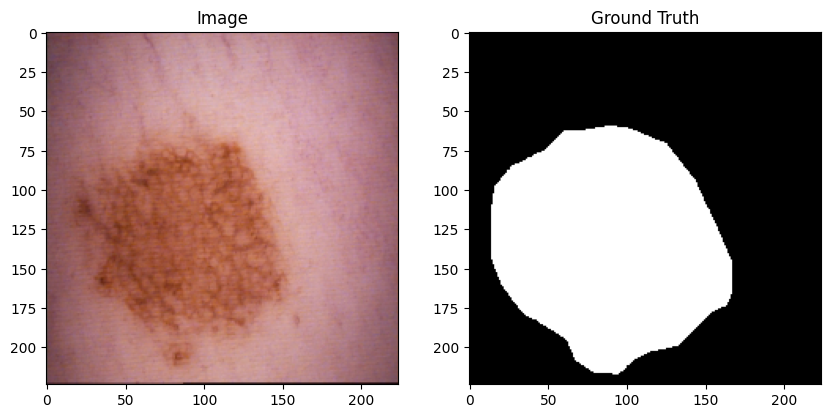

In [8]:
index = 35

image, mask = validset[index]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Image')
ax1.imshow(image.permute(1,2,0), cmap = 'gray')

ax2.set_title('Ground Truth')
ax2.imshow(mask.permute(1,2,0), cmap = 'gray')

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(validset, batch_size = batch_size)
test_loader = DataLoader(testset, batch_size = batch_size)

print("The total  number of batches in train loader are: ", len(train_loader))
print("The total  number of batches in valid loader are: ", len(valid_loader))
print("The total  number of batches in test loader are: ", len(test_loader))

The total  number of batches in train loader are:  163
The total  number of batches in valid loader are:  7
The total  number of batches in test loader are:  63


In [10]:
import torch as torch
import torch.nn as nn
from torchvision.models import resnet34, ResNet34_Weights

class AttentionGate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )

        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )

        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * g
    

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DoubleConv, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


class Decoder(nn.Module):
    def __init__(self, up_in_channels, x_in_channels, kernel_size=3, padding=1, dropout=0):
        super(Decoder, self).__init__()

        self.upsample = nn.ConvTranspose2d(up_in_channels, up_in_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)

        up_out_channels = up_in_channels // 2
        self.attention_gate = AttentionGate([up_out_channels, x_in_channels], up_out_channels)
        in_channels = up_in_channels // 2 + x_in_channels
        out_channels = in_channels // 2

        self.layers = DoubleConv(in_channels, out_channels, kernel_size, padding)

    def forward(self, skip_connection, x):
        x = self.upsample(x)
        
        # Store pre-attention features
        pre_attention = x
        
        # Apply attention
        post_attention = self.attention_gate(x, skip_connection)
        
        # Process and return all outputs
        output = self.layers(torch.cat([skip_connection, post_attention], dim=1))
        
        return output, pre_attention, post_attention


class AttenResUnet(nn.Module):
    def __init__(self, num_classes):

        backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        super(AttenResUnet, self).__init__()

        for param in backbone.parameters():
            param.requires_grad = False

        # backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder0 = nn.Sequential(
                        backbone.conv1, 
                        backbone.bn1, 
                        backbone.relu
                        )
        
        self.maxpool = backbone.maxpool

        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

        self.middle = DoubleConv(512, 512)

        self.decoder0 = Decoder(512, 256)
        self.decoder1 = Decoder(256, 128)
        self.decoder2 = Decoder(128, 64)
        self.decoder3 = Decoder(64, 64)

        self.resize = nn.ConvTranspose2d(48, 16, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.final_layer = nn.Sequential(
            nn.Conv2d(16, num_classes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True),
            )

        # For storing intermediate results
        self.intermediate_outputs = {}

    def forward(self, x, return_intermediates=False):
        a1 = self.encoder0(x)
        a1_pooled = self.maxpool(a1)
        a2 = self.encoder1(a1_pooled)
        a3 = self.encoder2(a2)
        a4 = self.encoder3(a3)
        a5 = self.encoder4(a4)

        mid = self.middle(a5)

        # Capture both outputs and intermediate attention results
        d1, pre_att0, post_att0 = self.decoder0(a4, mid)
        d2, pre_att1, post_att1 = self.decoder1(a3, d1)
        d3, pre_att2, post_att2 = self.decoder2(a2, d2)
        d4, pre_att3, post_att3 = self.decoder3(a1, d3)

        resized = self.resize(d4)
        final = self.final_layer(resized)

        if return_intermediates:
            self.intermediate_outputs = {
                # Encoder outputs
                'encoder1': a1,
                'encoder2': a2,
                'encoder3': a3,
                'encoder4': a4,
                'encoder5': a5,
                'middle': mid,
                
                # Decoder outputs
                'decoder1': d1,
                'decoder2': d2,
                'decoder3': d3,
                'decoder4': d4,
                
                # Pre-attention maps
                'pre_attention1': pre_att0,
                'pre_attention2': pre_att1,
                'pre_attention3': pre_att2,
                'pre_attention4': pre_att3,
                
                # Post-attention maps
                'post_attention1': post_att0,
                'post_attention2': post_att1,
                'post_attention3': post_att2,
                'post_attention4': post_att3,
            }
            return final, self.intermediate_outputs
        
        return final

In [11]:
import numpy as np
import torch.nn.functional as F

# Dice Loss
def dice_loss(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return 1 - ((2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth))

# IoU Loss
def iou_loss(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return 1 - ((intersection + smooth) / (union + smooth))

# Focal Loss (binary)
def focal_loss(preds, targets, alpha=0.8, gamma=2):
    BCE = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
    pt = torch.exp(-BCE)
    FL = alpha * (1 - pt) ** gamma * BCE
    return FL.mean()

# Tversky Loss
def tversky_loss(preds, targets, alpha=0.5, beta=0.5, smooth=1e-6):
    preds = torch.sigmoid(preds).view(-1)
    targets = targets.view(-1)
    TP = (preds * targets).sum()
    FP = ((1 - targets) * preds).sum()
    FN = (targets * (1 - preds)).sum()
    return 1 - ((TP + smooth) / (TP + alpha * FP + beta * FN + smooth))

# Dice Score for Evaluation
def dice_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))

    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()  # batch average

In [12]:
class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.dice_scores = []
        self.iou_losses = []
        self.focal_losses = []
        self.tversky_losses = []
        
    def update(self, train_loss, val_loss, dice_score, iou_loss, focal_loss, tversky_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.dice_scores.append(dice_score)
        self.iou_losses.append(iou_loss)
        self.focal_losses.append(focal_loss)
        self.tversky_losses.append(tversky_loss)
    
    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Training and Validation Loss
        axs[0, 0].plot(epochs, self.train_losses, 'b-', label='Training Loss')
        axs[0, 0].plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        axs[0, 0].set_title('Training and Validation Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()
        axs[0, 0].grid(True)
        
        # Plot 2: Dice Scores
        axs[0, 1].plot(epochs, self.dice_scores, 'g-')
        axs[0, 1].set_title('Dice Score')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Score')
        axs[0, 1].grid(True)
        
        # Plot 3: IoU and Tversky Losses
        axs[1, 0].plot(epochs, self.iou_losses, 'c-', label='IoU Loss')
        axs[1, 0].plot(epochs, self.tversky_losses, 'm-', label='Tversky Loss')
        axs[1, 0].set_title('IoU and Tversky Losses')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].legend()
        axs[1, 0].grid(True)
        
        # Plot 4: Focal Loss
        axs[1, 1].plot(epochs, self.focal_losses, 'y-')
        axs[1, 1].set_title('Focal Loss')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Additionally plot training vs validation loss in a separate figure
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [13]:
# Initialize model and training components
model = AttenResUnet(1).to(device)
criterian = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Initialize metrics tracker
metrics_tracker = MetricsTracker()

num_epochs = 10
for epoch in range(num_epochs):
    
    # --- Training Loop ---
    model.train()
    epoch_loss = 0
    
    # Use tqdm for progress bar
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterian(preds, masks)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    scheduler.step()
    avg_train_loss = epoch_loss / len(train_loader)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0
    val_dice = 0
    last_iou = 0
    last_focal = 0
    last_tversky = 0
    
    with torch.no_grad():
        for val_imgs, val_masks in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
    
            val_preds = model(val_imgs)
            loss = criterian(val_preds, val_masks)
            val_loss += loss.item()
    
            # Compute metrics (we'll save the last batch's metrics for tracking)
            sigmoid_preds = torch.sigmoid(val_preds)
            dice = dice_score(val_preds, val_masks)
            val_dice += dice.item()
            
            # Calculate other metrics on last batch
            last_iou = iou_loss(sigmoid_preds, val_masks).item()
            last_focal = focal_loss(val_preds, val_masks).item()
            last_tversky = tversky_loss(val_preds, val_masks).item()
    
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_dice = val_dice / len(valid_loader)
    
    # Store metrics
    metrics_tracker.update(
        avg_train_loss, 
        avg_val_loss, 
        avg_val_dice, 
        last_iou, 
        last_focal, 
        last_tversky
    )
    
    # Print only the essential information
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]


Epoch 1/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.6217, Val Loss: 0.5968


Epoch 2/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.6061, Val Loss: 0.5870


Epoch 3/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.6003, Val Loss: 0.5826


Epoch 4/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.5995, Val Loss: 0.5777


Epoch 5/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.5977, Val Loss: 0.5789


Epoch 6/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.5967, Val Loss: 0.5786


Epoch 7/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.5974, Val Loss: 0.5786


Epoch 8/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.5968, Val Loss: 0.5781


Epoch 9/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.5975, Val Loss: 0.5786


Epoch 10/10 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.5970, Val Loss: 0.5787


In [14]:
model_save_path = "/kaggle/working/attenresunet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /kaggle/working/attenresunet.pth


Evaluating test data:   0%|          | 0/63 [00:00<?, ?it/s]


===== Test Dataset Evaluation =====
Loss: 0.5810
Dice Score: 0.8534
IoU Score: 0.3592
Focal Loss: 0.1263
Tversky Loss: 0.4739


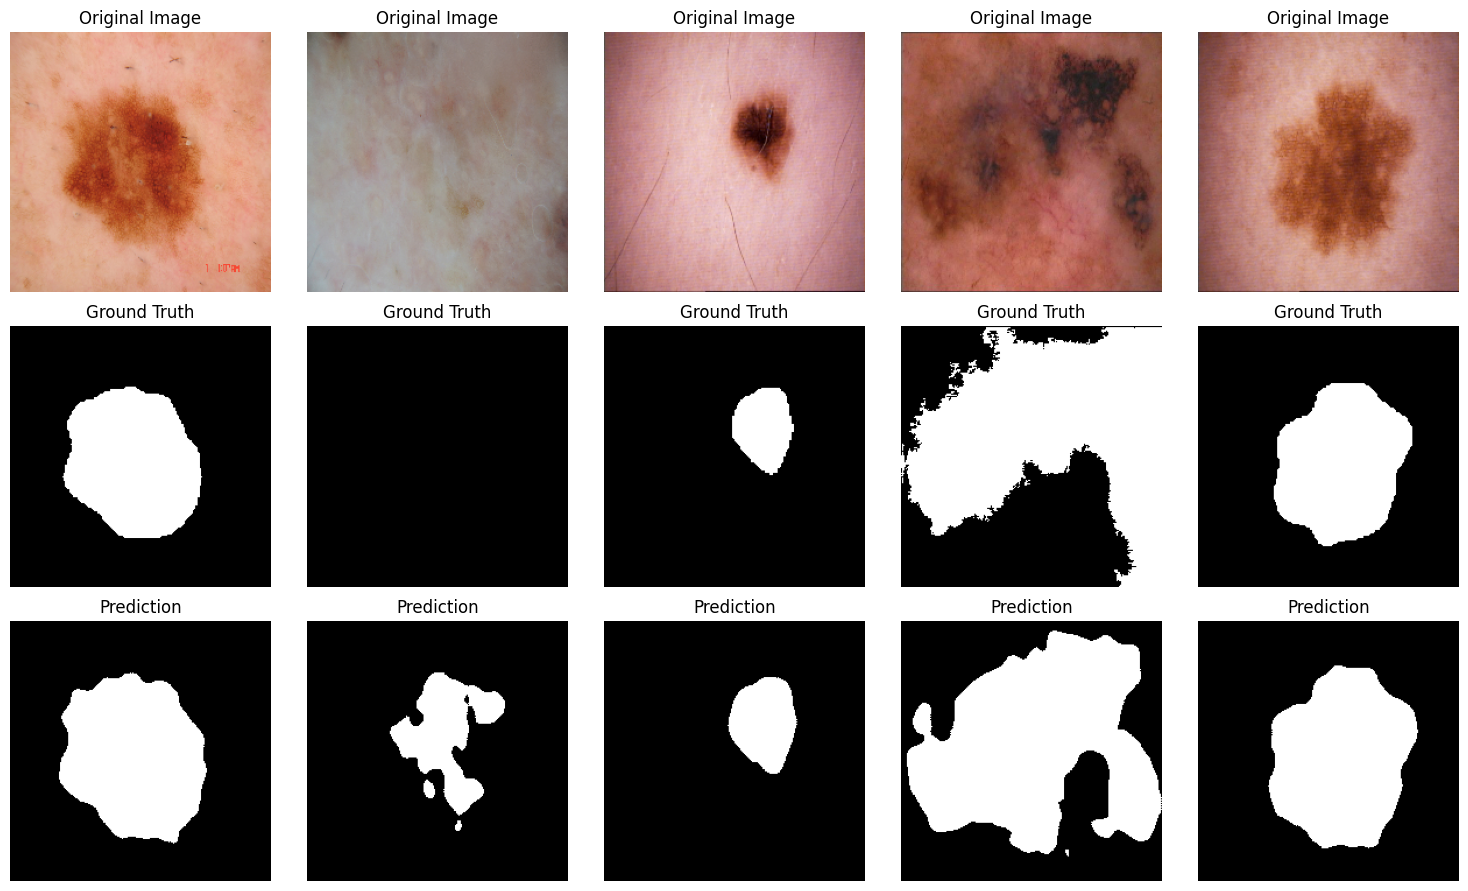

In [15]:
def evaluate_test_data(model, test_loader, criterion):
    """
    Evaluates model on test data and returns comprehensive metrics
    
    Args:
        model: The trained model to evaluate
        test_loader: DataLoader containing test data
        criterion: Loss function used for evaluation
    
    Returns:
        Dictionary of metrics
    """
    model.eval()
    test_loss = 0
    test_dice = 0
    test_iou = 0
    test_focal = 0
    test_tversky = 0
    test_samples = 0
    
    with torch.no_grad():
        for test_imgs, test_masks in tqdm(test_loader, desc="Evaluating test data"):
            test_imgs, test_masks = test_imgs.to(device), test_masks.to(device)
            
            # Forward pass
            test_preds = model(test_imgs)
            
            # Calculate primary loss
            loss = criterion(test_preds, test_masks)
            test_loss += loss.item() * test_imgs.size(0)
            
            # Calculate metrics
            sigmoid_preds = torch.sigmoid(test_preds)
            dice = dice_score(test_preds, test_masks)
            
            # Add metrics
            test_dice += dice.item() * test_imgs.size(0)
            test_iou += (1 - iou_loss(sigmoid_preds, test_masks).item()) * test_imgs.size(0)
            test_focal += focal_loss(test_preds, test_masks).item() * test_imgs.size(0)
            test_tversky += tversky_loss(test_preds, test_masks).item() * test_imgs.size(0)
            
            test_samples += test_imgs.size(0)
    
    # Normalize metrics by total samples
    metrics = {
        'loss': test_loss / test_samples,
        'dice_score': test_dice / test_samples,
        'iou_score': test_iou / test_samples,
        'focal_loss': test_focal / test_samples,
        'tversky_loss': test_tversky / test_samples
    }
    
    return metrics

def visualize_test_predictions(model, test_loader, num_samples=5):
    """
    Visualizes test predictions alongside original images and ground truth masks
    
    Args:
        model: The trained model to evaluate
        test_loader: DataLoader containing test data
        num_samples: Number of samples to visualize
    """
    model.eval()
    with torch.no_grad():
        # Get a batch from the test loader
        imgs, masks = next(iter(test_loader))
        imgs = imgs.to(device)
        
        # Generate predictions
        preds = torch.sigmoid(model(imgs)) > 0.5
        
        # Limit to specified number of samples
        n = min(num_samples, imgs.size(0))
        
        # Create visualization figure
        fig, axs = plt.subplots(3, n, figsize=(n*3, 9))
        
        for i in range(n):
            # Display original image
            axs[0, i].imshow(imgs[i].cpu().permute(1, 2, 0))
            axs[0, i].set_title("Original Image")
            axs[0, i].axis('off')
            
            # Display ground truth mask
            axs[1, i].imshow(masks[i].squeeze(0), cmap='gray')
            axs[1, i].set_title("Ground Truth")
            axs[1, i].axis('off')
            
            # Display prediction mask
            axs[2, i].imshow(preds[i].squeeze(0).cpu(), cmap='gray')
            axs[2, i].set_title("Prediction")
            axs[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Main evaluation code
test_metrics = evaluate_test_data(model, test_loader, criterian)

# Display summary of test metrics
print("\n===== Test Dataset Evaluation =====")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Dice Score: {test_metrics['dice_score']:.4f}")
print(f"IoU Score: {test_metrics['iou_score']:.4f}")
print(f"Focal Loss: {test_metrics['focal_loss']:.4f}")
print(f"Tversky Loss: {test_metrics['tversky_loss']:.4f}")

# Visualize predictions
visualize_test_predictions(model, test_loader, num_samples=5)

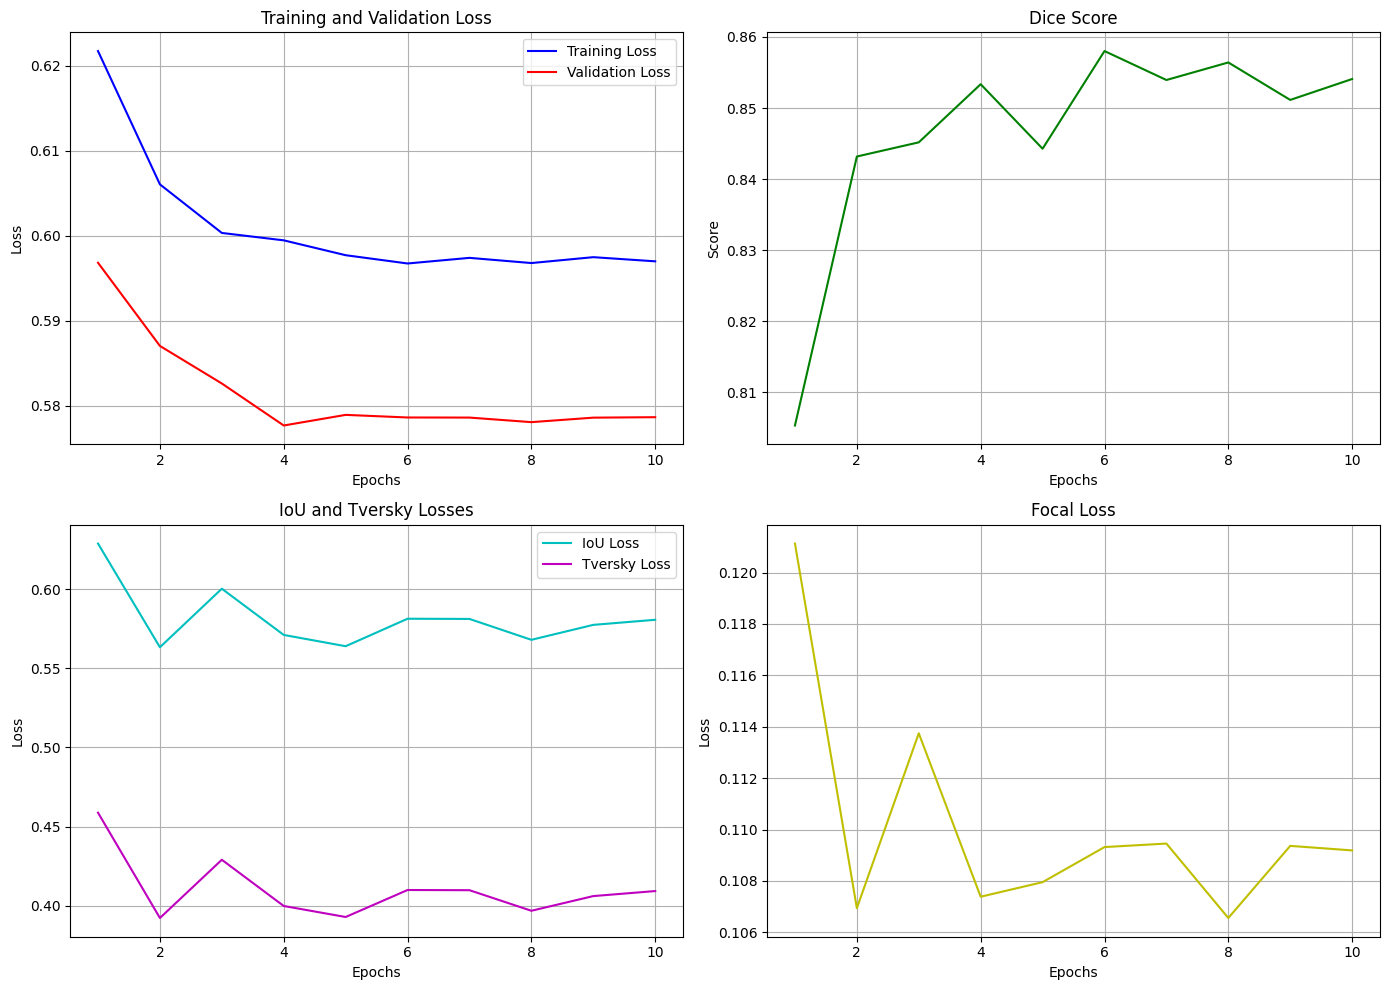

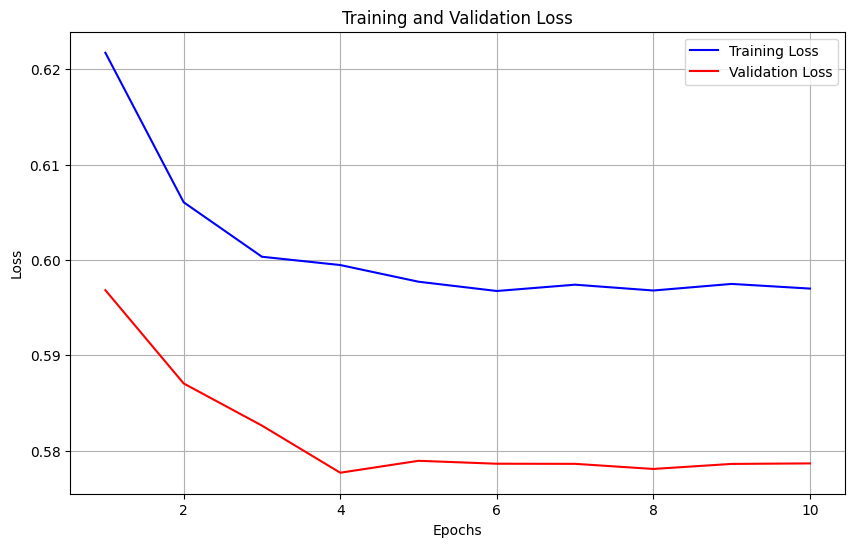

In [16]:
# Plot all metrics after training
metrics_tracker.plot_metrics()

### Code to Visualize Outputs of Various Encoder-Decoder Layers After & Before Attention

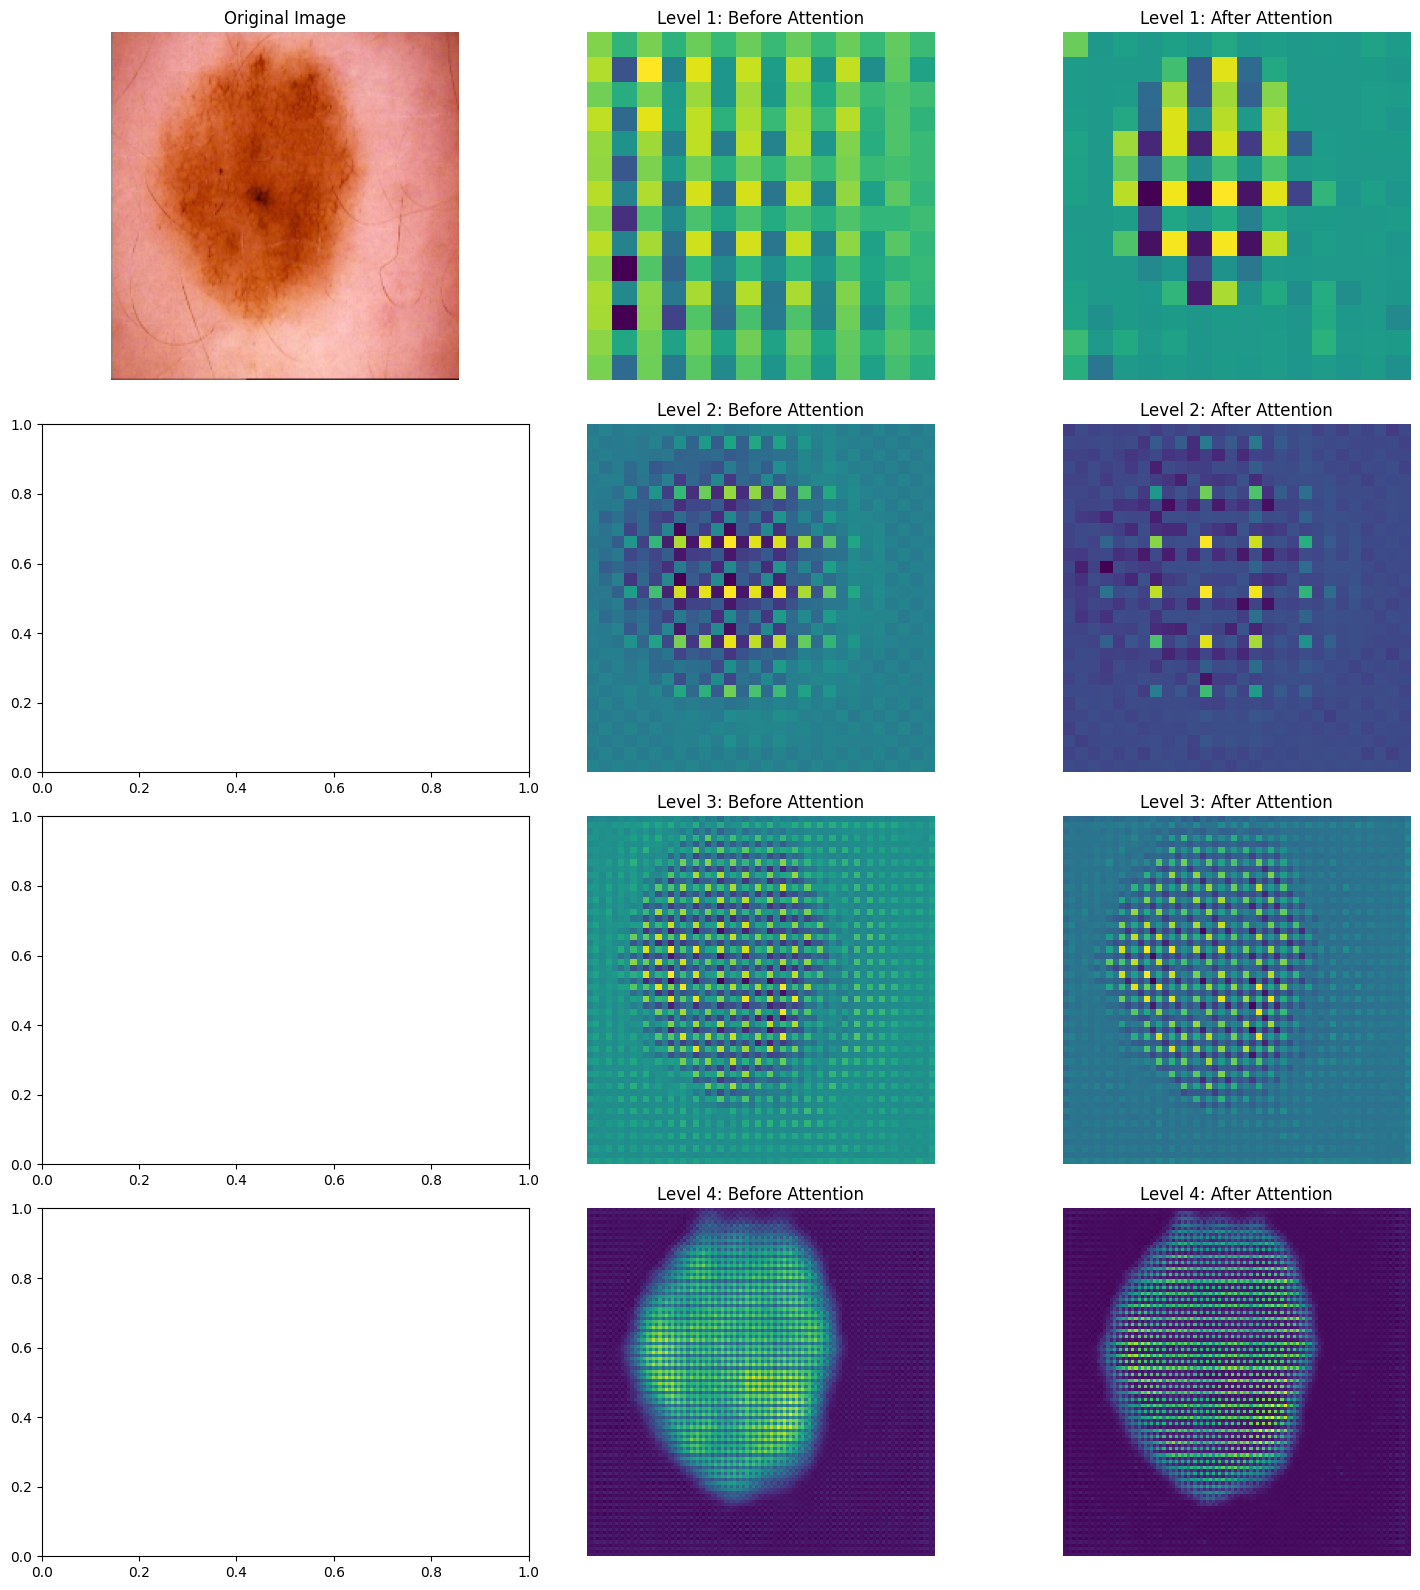

In [17]:
def visualize_attention_maps(model, input_batch, sample_idx=0):
    """
    Visualizes the feature maps before and after attention gates
    
    Args:
        model: Trained AttenResUnet model
        input_batch: Batch of images [B, C, H, W]
        sample_idx: Index of the sample to visualize from the batch
    """
    model.eval()
    with torch.no_grad():
        # Forward pass with intermediate outputs
        _, intermediates = model(input_batch, return_intermediates=True)
        
        # Original image for reference
        original_img = input_batch[sample_idx].cpu().permute(1, 2, 0)
        
        # Create figure
        fig, axes = plt.subplots(4, 3, figsize=(15, 16))
        
        # Display original image in first column
        axes[0, 0].imshow(original_img)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # For each decoder level
        for i in range(4):
            # Get pre and post attention feature maps for current level
            pre_att = intermediates[f'pre_attention{i+1}'][sample_idx]
            post_att = intermediates[f'post_attention{i+1}'][sample_idx]
            
            # Reduce channels by taking mean
            pre_att_mean = pre_att.mean(dim=0).cpu().numpy()
            post_att_mean = post_att.mean(dim=0).cpu().numpy()
            
            # Normalize for better visualization
            pre_att_mean = (pre_att_mean - pre_att_mean.min()) / (pre_att_mean.max() - pre_att_mean.min() + 1e-8)
            post_att_mean = (post_att_mean - post_att_mean.min()) / (post_att_mean.max() - post_att_mean.min() + 1e-8)
            
            # Show feature maps
            axes[i, 1].imshow(pre_att_mean, cmap='viridis')
            axes[i, 1].set_title(f'Level {i+1}: Before Attention')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(post_att_mean, cmap='viridis')
            axes[i, 2].set_title(f'Level {i+1}: After Attention')
            axes[i, 2].axis('off')
            
        plt.tight_layout()
        plt.show()

# Example usage with trained model
with torch.no_grad():
    sample_batch, _ = next(iter(valid_loader))
    sample_batch = sample_batch.to(device)
    visualize_attention_maps(model, sample_batch)